# Regression with an Abalone Dataset
## Цель - предсказать возраст моллюска на основе различных физических измерений.
## Модель: Lasso
##### Должно быть выполнено:
- **Исследовательский анализ данных (EDA)**
- **Предварительная обработка данных**
- **Построение и оценка модели**
## Краткие теоретические сведения
Метод регрессии лассо (LASSO, Least Absolute Shrinkage and Selection Operator) — это вариация линейной регрессии, специально адаптированная для данных, которые демонстрируют сильную мультиколлинеарность (то есть сильную корреляцию признаков друг с другом). Она автоматизирует части выбора модели, такие как выбор переменных или исключение параметров. LASSO использует сжатие коэффициентов (shrinkage), то есть процесс, в котором значения данных приближаются к центральной точке (например среднему значению).
Процесс сжатия добавляет регрессионным моделям несколько преимуществ:
- **Более точные и стабильные оценки истинных параметров.**
- **Уменьшение ошибок выборки и отсутствия выборки.**
- **Сглаживание пространственных флуктуаций.**

Вместо того чтобы корректировать сложность модели, компенсируя сложность данных, подобно методам регрессии с высокой дисперсией нейронных сетей и дерева решений, лассо пытается уменьшить сложность данных так, чтобы их можно было обрабатывать простыми методами регрессии, искривляя пространство, на котором они лежат. В этом процессе лассо автоматически помогает устранить или исказить сильно коррелированные и избыточные функции в методе с низкой дисперсией.
Регрессия лассо использует регуляризацию L1, то есть взвешивает ошибки по их абсолютному значению. Вместо, например, регуляризации L2, которая взвешивает ошибки по их квадрату, чтобы сильнее наказывать за более значительные ошибки.
Такая регуляризация часто приводит к более разреженным моделям с меньшим количеством коэффициентов, так как некоторые коэффициенты могут стать нулевыми и, следовательно, будут исключены из модели. Это позволяет ее интерпретировать.

#### 1. Исследовательский анализ данных (EDA)
##### 1.1. Загрузка данных

In [27]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("data.csv")

##### 1.2. Первичный осмотр данных

In [28]:
# Первые 5 строк
print(data.head())

# Информация о данных
print(data.info())

# Статистические характеристики
print(data.describe())

   id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   

##### 1.3. Визуализация данных
- **Распределение возраста моллюсков**: Возраст будет вычисляться как `Rings + 1.5` (где 1.5 - это средний возраст моллюска, когда он достигает первого кольца).

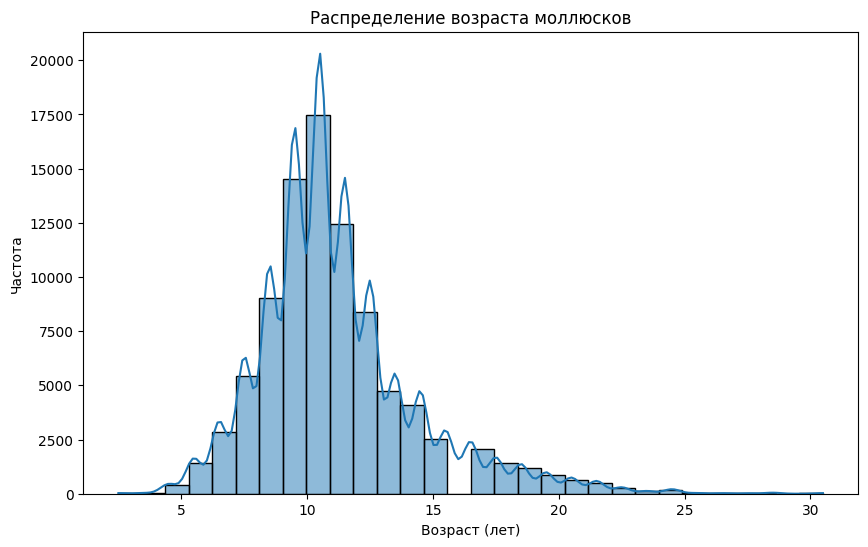

In [29]:
# Вычисление возраста
data['Age'] = data['Rings'] + 1.5

# Визуализация распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Распределение возраста моллюсков')
plt.xlabel('Возраст (лет)')
plt.ylabel('Частота')
plt.show()

- **Корреляция между переменными**:

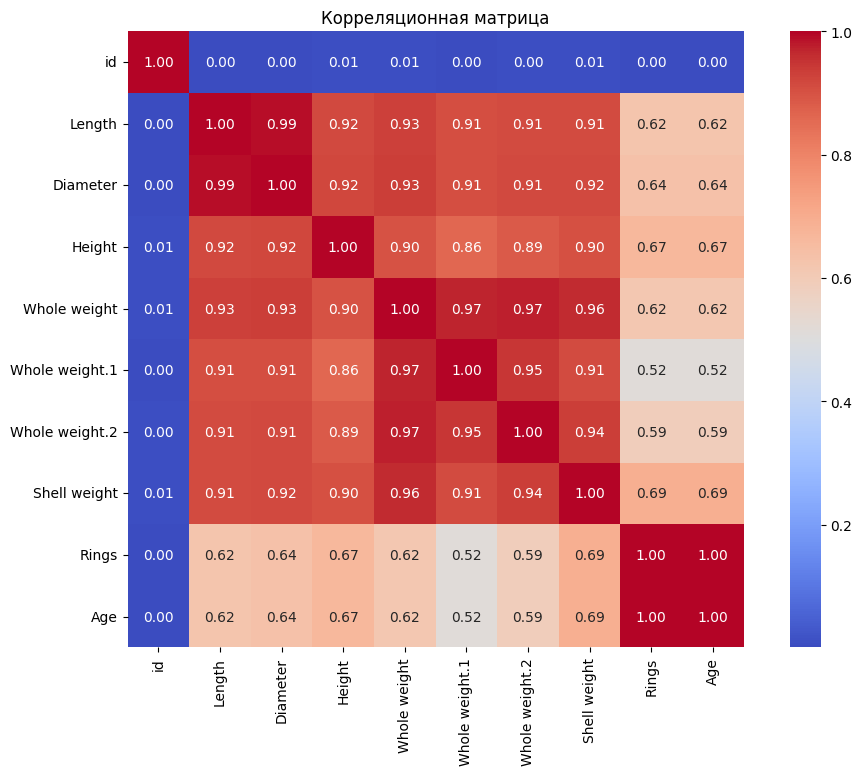

In [30]:
# Корреляция
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

##### 1.4. Анализ категориальных данных
Посмотрим на распределение пола моллюсков (Sex).

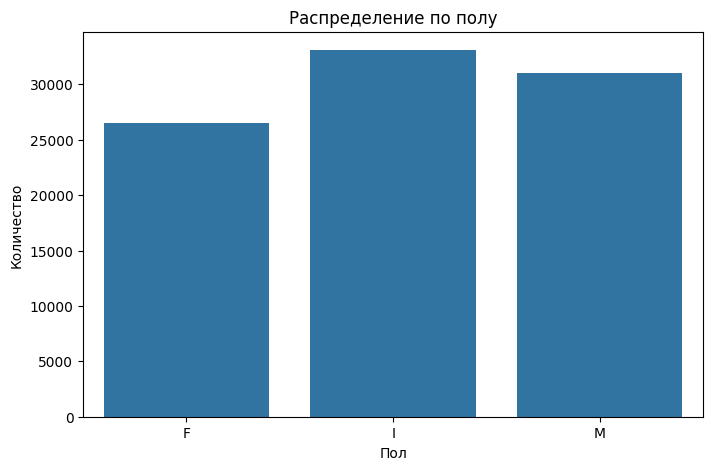

In [31]:
# Распределение по полу
plt.figure(figsize=(8, 5))
sns.countplot(x='Sex', data=data)
plt.title('Распределение по полу')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.show()

#### 2. Предварительная обработка данных

##### 2.1. Кодирование категориальных переменных

Преобразуем категориальные переменные (пол) в числовые.

In [32]:
# Кодирование пола
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

##### 2.2. Разделение данных на признаки и целевую переменную

In [33]:
# Разделение на признаки и целевую переменную
X = data.drop(columns=['Rings', 'Age'])
y = data['Age']

##### 2.3. Масштабирование данных

Проведем масштабирование данных с использованием StandardScaler.

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### 2.4. Разделение на обучающую и тестовую выборки

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### 3. Построение и оценка модели Lasso

##### 3.1. Импорт необходимых библиотек

In [36]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

##### 3.2. Обучение модели Lasso
Используем LassoCV для подбора параметра регуляризации.

In [37]:
# Обучение модели Lasso
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Вывод лучшего альфа
print("Лучшее значение alpha:", lasso.alpha_)

Лучшее значение alpha: 0.0001


##### 3.3. Оценка модели

In [38]:
# Предсказания
y_pred = lasso.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 4.10
R^2 Score: 0.60


##### 3.4. Визуализация предсказаний

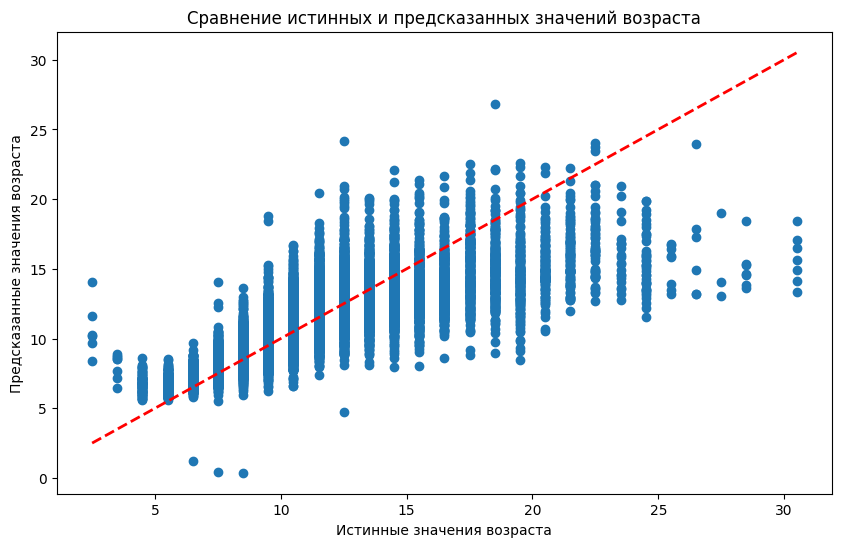

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Истинные значения возраста')
plt.ylabel('Предсказанные значения возраста')
plt.title('Сравнение истинных и предсказанных значений возраста')
plt.show()